Baseline (historical) data sample:
   transaction_amount  account_balance  num_transactions
0          968.125174      4124.186595                16
1          989.412023      5857.449029                 9
2         1214.164903      5968.686844                15
3          854.063210      3614.917304                 5
4          982.274418      5698.604849                10

Please upload your new data (CSV or Excel). If cancelled, synthetic data will be used.


Saving Demo_AI_driftdata.xlsx to Demo_AI_driftdata (11).xlsx

New data sample (Demo_AI_driftdata (11).xlsx):
   transaction_amount  account_balance  num_transactions
0                1020             5200               210
1                 980             4800                 9
2                1100             5300                12
3                1150             5100                 8

=== Drift Report ===
              Feature     PSI  KL Divergence  Drift Detected
0  transaction_amount  1.1188         7.1580            True
1     account_balance  0.8213        10.8301            True
2    num_transactions  0.9508        12.3482            True


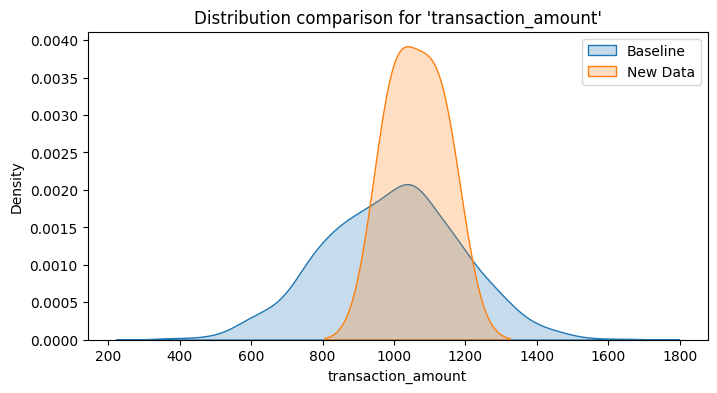

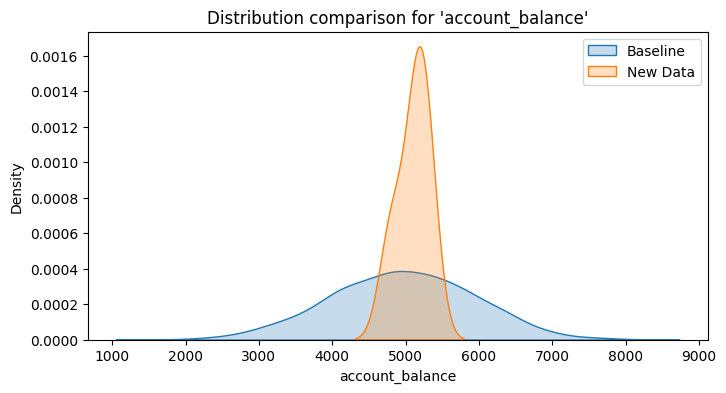

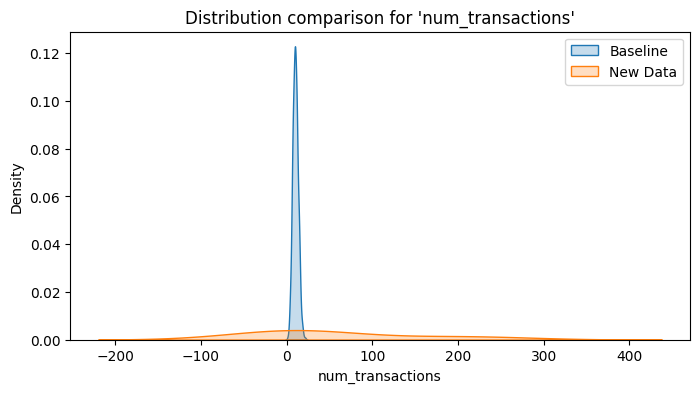

In [13]:
# ===========================
# AI Drift Detector (Without Labels)
# Finance-related dataset drift detection
# ===========================

# Step 1: Install required libraries
!pip install pandas numpy matplotlib seaborn openpyxl --quiet

# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from google.colab import files

# ===========================
# Step 3: Helper functions
# ===========================

def calculate_psi(expected, actual, bins=10):
    breakpoints = np.linspace(np.min(expected), np.max(expected), bins + 1)
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]
    expected_counts = np.where(expected_counts == 0, 1, expected_counts)
    actual_counts = np.where(actual_counts == 0, 1, actual_counts)
    expected_perc = expected_counts / np.sum(expected_counts)
    actual_perc = actual_counts / np.sum(actual_counts)
    psi_value = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return psi_value

def calculate_kl_divergence(expected, actual, bins=10):
    breakpoints = np.linspace(np.min(expected), np.max(expected), bins + 1)
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]
    expected_prob = expected_counts / np.sum(expected_counts)
    actual_prob = actual_counts / np.sum(actual_counts)
    epsilon = 1e-10
    kl_value = entropy(expected_prob + epsilon, actual_prob + epsilon)
    return kl_value

def detect_drift(baseline_df, new_df, psi_threshold=0.2, kl_threshold=0.1):
    results = []
    numeric_features = baseline_df.select_dtypes(include=[np.number]).columns
    for feature in numeric_features:
        psi = calculate_psi(baseline_df[feature], new_df[feature])
        kl = calculate_kl_divergence(baseline_df[feature], new_df[feature])
        drift_flag = (psi > psi_threshold) or (kl > kl_threshold)
        results.append({
            "Feature": feature,
            "PSI": round(psi, 4),
            "KL Divergence": round(kl, 4),
            "Drift Detected": drift_flag
        })
    return pd.DataFrame(results)

# ===========================
# Step 4: Baseline historical data
# ===========================

# np.random.seed(42)
baseline_data = pd.DataFrame({
    "transaction_amount": np.random.normal(1000, 200, 1000),
    "account_balance": np.random.normal(5000, 1000, 1000),
    "num_transactions": np.random.poisson(10, 1000)
})

print("Baseline (historical) data sample:")
print(baseline_data.head())

# ===========================
# Step 5: Upload new data
# ===========================

print("\nPlease upload your new data (CSV or Excel). If cancelled, synthetic data will be used.")
uploaded = files.upload()

if uploaded:
    for filename in uploaded.keys():
        if filename.endswith((".xls", ".xlsx")):
            new_data = pd.read_excel(filename)
        else:
            new_data = pd.read_csv(filename)
        print(f"\nNew data sample ({filename}):")
        print(new_data.head())
else:
    print("\nNo file uploaded. Using synthetic new data for demo.")
    new_data = pd.DataFrame({
        "transaction_amount": np.random.normal(1200, 300, 1000),
        "account_balance": np.random.normal(5500, 1200, 1000),
        "num_transactions": np.random.poisson(12, 1000)
    })
    print(new_data.head())

# Make sure columns match baseline
new_data.columns = baseline_data.columns

# ===========================
# Step 6: Detect drift
# ===========================

drift_report = detect_drift(baseline_data, new_data)
print("\n=== Drift Report ===")
print(drift_report)

# ===========================
# Step 7: Visualize drift
# ===========================

numeric_features = baseline_data.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(baseline_data[feature], label="Baseline", fill=True)
    sns.kdeplot(new_data[feature], label="New Data", fill=True)
    plt.title(f"Distribution comparison for '{feature}'")
    plt.legend()
    plt.show()
